In [1]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import pyLDAvis
import pyLDAvis.gensim  

import spacy
from spacy.lemmatizer import Lemmatizer
from spacy.lang.en.stop_words import STOP_WORDS

from textblob import TextBlob

from tqdm import tqdm_notebook as tqdm
from pprint import pprint
import warnings
warnings.filterwarnings('ignore')

C:\Users\HP\Anaconda3\lib\site-packages\nltk\decorators.py:68: DeprecationWarning: `formatargspec` is deprecated since Python 3.5. Use `signature` and the `Signature` object directly
  regargs, varargs, varkwargs, defaults, formatvalue=lambda value: ""
C:\Users\HP\Anaconda3\lib\site-packages\nltk\lm\counter.py:15: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sequence, defaultdict


In [2]:
df1 = pd.read_csv('ethiopia_tripadvisor_data_model_3.csv')
df1.head()

,Destination Name,Destination Type,Review Head,Review Body,Review Text,RB_Sentence1,TextBlob Polarity Head,TextBlob Polarity Body,TextBlob Polarity Text,TextBlob Polarity RBS1,RB_Sentence1_Split
0,Rock-Hewn Churches of Lalibela,Landmarks,Incredible locations don't be put off thinking...,Amazing location must visit. This site is mark...,Incredible locations don't be put off thinking...,Amazing location must visit.,-0.05,0.300000,0.125000,0.6000,"['Amazing', 'location', 'must', 'visit.']"
1,Rock-Hewn Churches of Lalibela,Landmarks,It is a real miracle of the world!,I do recommend to visit Lalibela churches and ...,It is a real miracle of the world! I do recomm...,I do recommend to visit Lalibela churches and ...,0.25,-0.150000,-0.016667,0.0000,"['I', 'do', 'recommend', 'to', 'visit', 'Lalib..."
2,Rock-Hewn Churches of Lalibela,Landmarks,Incredible experience,A must visit in Ethiopia - one of the most uni...,Incredible experience A must visit in Ethiopia...,A must visit in Ethiopia - one of the most uni...,0.90,0.345000,0.483750,0.4375,"['A', 'must', 'visit', 'in', 'Ethiopia', '-', ..."
3,Rock-Hewn Churches of Lalibela,Landmarks,Amazing,These churches have to be seen to be believed....,Amazing These churches have to be seen to be b...,These churches have to be seen to be believed.,0.60,0.225000,0.350000,0.0000,"['These', 'churches', 'have', 'to', 'be', 'see..."
4,Rock-Hewn Churches of Lalibela,Landmarks,So much history,Thanks to our tour organiser Ephram who is bas...,So much history Thanks to our tour organiser E...,Thanks to our tour organiser Ephram who is bas...,0.20,0.233333,0.228571,0.2000,"['Thanks', 'to', 'our', 'tour', 'organiser', '..."


In [3]:
df1['RH_Split'] = df1['Review Head'].apply(lambda x: x.split(' '))
df1['RB_Split'] = df1['Review Body'].apply(lambda x: x.split(' '))
df1['RT_Split'] = df1['Review Text'].apply(lambda x: x.split(' '))
df1['RB_Sentence1_Split'] = df1['RB_Sentence1'].apply(lambda x: x.split(' '))
df1.head()

,Destination Name,Destination Type,Review Head,Review Body,Review Text,RB_Sentence1,TextBlob Polarity Head,TextBlob Polarity Body,TextBlob Polarity Text,TextBlob Polarity RBS1,RB_Sentence1_Split,RH_Split,RB_Split,RT_Split
0,Rock-Hewn Churches of Lalibela,Landmarks,Incredible locations don't be put off thinking...,Amazing location must visit. This site is mark...,Incredible locations don't be put off thinking...,Amazing location must visit.,-0.05,0.300000,0.125000,0.6000,"[Amazing, location, must, visit.]","[Incredible, locations, don't, be, put, off, t...","[Amazing, location, must, visit., This, site, ...","[Incredible, locations, don't, be, put, off, t..."
1,Rock-Hewn Churches of Lalibela,Landmarks,It is a real miracle of the world!,I do recommend to visit Lalibela churches and ...,It is a real miracle of the world! I do recomm...,I do recommend to visit Lalibela churches and ...,0.25,-0.150000,-0.016667,0.0000,"[I, do, recommend, to, visit, Lalibela, church...","[It, is, a, real, miracle, of, the, world!]","[I, do, recommend, to, visit, Lalibela, church...","[It, is, a, real, miracle, of, the, world!, I,..."
2,Rock-Hewn Churches of Lalibela,Landmarks,Incredible experience,A must visit in Ethiopia - one of the most uni...,Incredible experience A must visit in Ethiopia...,A must visit in Ethiopia - one of the most uni...,0.90,0.345000,0.483750,0.4375,"[A, must, visit, in, Ethiopia, -, one, of, the...","[Incredible, experience, ]","[A, must, visit, in, Ethiopia, -, one, of, the...","[Incredible, experience, A, must, visit, in, E..."
3,Rock-Hewn Churches of Lalibela,Landmarks,Amazing,These churches have to be seen to be believed....,Amazing These churches have to be seen to be b...,These churches have to be seen to be believed.,0.60,0.225000,0.350000,0.0000,"[These, churches, have, to, be, seen, to, be, ...",[Amazing],"[These, churches, have, to, be, seen, to, be, ...","[Amazing, These, churches, have, to, be, seen,..."
4,Rock-Hewn Churches of Lalibela,Landmarks,So much history,Thanks to our tour organiser Ephram who is bas...,So much history Thanks to our tour organiser E...,Thanks to our tour organiser Ephram who is bas...,0.20,0.233333,0.228571,0.2000,"[Thanks, to, our, tour, organiser, Ephram, who...","[So, much, history]","[Thanks, to, our, tour, organiser, Ephram, who...","[So, much, history, Thanks, to, our, tour, org..."


In [4]:
df1['Destination Type'].value_counts()

Landmarks       3803
Museums         2507
Nature/Parks    2001
Name: Destination Type, dtype: int64

### Topic Modelling

In [5]:
# NLTK Stop words
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

test_subset = df1['RB_Split'].values
sid = SentimentIntensityAnalyzer()
pos_word_list=[]
neu_word_list=[]
neg_word_list=[]

for value in test_subset:
    for word in value:
        if (sid.polarity_scores(word)['compound']) >= 0.4:
            pos_word_list.append(word)
        elif (sid.polarity_scores(word)['compound']) <= -0.4:
            print
            neg_word_list.append(word)
        else:
            neu_word_list.append(word)                

print('Positive :', len(pos_word_list))       
print('Neutral :', len(neu_word_list))    
print('Negative :', len(neg_word_list)) 

Positive : 13151
Neutral : 309837
Negative : 1632


In [6]:
from nltk.corpus import stopwords

main_stop_words = ['ethiopia', 'ethiopian', 'rock', 'hewn', 'church', 'churches', 'park', 'parks', 'museum', 
                       'museums', 'omo', 'valley', 'mountain', 'mountains', 'addis', 'ababa', 'lucy', 'simien', 
                       'national', 'lalibela', 'gelada', 'haile', 'selassie', 'gondar', 'africa' , 'harar', 
                       'cathedral', 'cathedrals', 'place', 'visit', 'girmay', 
                       '\n', '‘s']
positive_stop_words = list(set(pos_word_list))
negative_stop_words = list(set(neg_word_list))
total_stop_words = main_stop_words + positive_stop_words + negative_stop_words

stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])
stop_words.extend(total_stop_words)
print('Stop Words: ', len(stop_words))

Stop Words:  1724


In [7]:
# Convert to list
data = df1[df1['Destination Type'] == 'Landmarks'][df1['TextBlob Polarity Body'] < 0]['Review Body'].values.tolist()

# Remove Emails
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

pprint(data[:1])

['I do recommend to visit Lalibela churches and then have a mule trip to the '
 'mountain monastery. I would say you need at least two days for this city. I '
 'can also recommend a local guide who can arrange tours to all over in '
 'Ethiopia...']


In [8]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['do', 'recommend', 'to', 'visit', 'lalibela', 'churches', 'and', 'then', 'have', 'mule', 'trip', 'to', 'the', 'mountain', 'monastery', 'would', 'say', 'you', 'need', 'at', 'least', 'two', 'days', 'for', 'this', 'city', 'can', 'also', 'recommend', 'local', 'guide', 'who', 'can', 'arrange', 'tours', 'to', 'all', 'over', 'in', 'ethiopia']]


In [9]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['do', 'recommend', 'to', 'visit', 'lalibela', 'churches', 'and', 'then', 'have', 'mule', 'trip', 'to', 'the', 'mountain', 'monastery', 'would', 'say', 'you', 'need', 'at', 'least', 'two', 'days', 'for', 'this', 'city', 'can', 'also', 'recommend', 'local', 'guide', 'who', 'can', 'arrange', 'tours', 'to', 'all', 'over', 'in', 'ethiopia']


In [10]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [11]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['recommend', 'mule', 'trip', 'monastery', 'say', 'least', 'day', 'city', 'also', 'recommend', 'local', 'guide', 'arrange', 'tour']]


In [12]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 2), (10, 1), (11, 1), (12, 1)]]


In [13]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('also', 1),
  ('arrange', 1),
  ('city', 1),
  ('day', 1),
  ('guide', 1),
  ('least', 1),
  ('local', 1),
  ('monastery', 1),
  ('mule', 1),
  ('recommend', 2),
  ('say', 1),
  ('tour', 1),
  ('trip', 1)]]

In [14]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [15]:
# Print the Keyword in the n topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.040*"find" + 0.032*"really" + 0.026*"worth" + 0.025*"fee" + '
  '0.024*"entrance" + 0.023*"take" + 0.022*"see" + 0.019*"history" + '
  '0.019*"full" + 0.018*"actually"'),
 (1,
  '0.076*"say" + 0.033*"away" + 0.026*"empty" + 0.025*"see" + '
  '0.023*"participate" + 0.020*"become" + 0.012*"site" + 0.012*"wall" + '
  '0.012*"picture" + 0.011*"reason"'),
 (2,
  '0.041*"feel" + 0.033*"carpet" + 0.026*"want" + 0.023*"see" + 0.022*"still" '
  '+ 0.020*"visit" + 0.020*"consider" + 0.019*"christianity" + 0.018*"little" '
  '+ 0.017*"walk"'),
 (3,
  '0.071*"area" + 0.030*"less" + 0.027*"include" + 0.025*"avoid" + '
  '0.023*"service" + 0.017*"try" + 0.015*"arrive" + 0.015*"worth" + '
  '0.014*"big" + 0.012*"keep"'),
 (4,
  '0.052*"see" + 0.045*"tour" + 0.042*"give" + 0.036*"go" + 0.036*"way" + '
  '0.029*"take" + 0.024*"think" + 0.023*"guide" + 0.022*"shoe" + '
  '0.017*"usually"'),
 (5,
  '0.054*"day" + 0.042*"trip" + 0.027*"town" + 0.026*"buy" + 0.025*"religious" '
  '+ 0.023*"direct

In [16]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.691755243942892

Coherence Score:  0.4240130100866259


In [17]:
# # Visualize the topics
# pyLDAvis.enable_notebook()
# vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
# vis

In [18]:
# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
import os
os.environ.update({'MALLET_HOME':r'C:/Users/HP/mallet-2.0.8/'})
mallet_path = r'C:\Users\HP\mallet-2.0.8\bin\mallet' # update this path
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=10, id2word=id2word)

In [19]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(0,
  [('find', 0.06707317073170732),
   ('city', 0.04573170731707317),
   ('building', 0.03048780487804878),
   ('wall', 0.03048780487804878),
   ('include', 0.027439024390243903),
   ('tomb', 0.027439024390243903),
   ('structure', 0.024390243902439025),
   ('cost', 0.024390243902439025),
   ('timket', 0.018292682926829267),
   ('pass', 0.018292682926829267)]),
 (1,
  [('guide', 0.12461059190031153),
   ('tour', 0.06542056074766354),
   ('fee', 0.0529595015576324),
   ('priest', 0.03115264797507788),
   ('complex', 0.024922118380062305),
   ('emperor', 0.021806853582554516),
   ('admission', 0.018691588785046728),
   ('provide', 0.01557632398753894),
   ('significance', 0.01557632398753894),
   ('main', 0.01557632398753894)]),
 (2,
  [('worth', 0.06764705882352941),
   ('expensive', 0.04411764705882353),
   ('bit', 0.041176470588235294),
   ('give', 0.03823529411764706),
   ('arrive', 0.03529411764705882),
   ('ticket', 0.03235294117647059),
   ('leave', 0.029411764705882353),
   ('

2
3
4
5
6
7
8
9
10


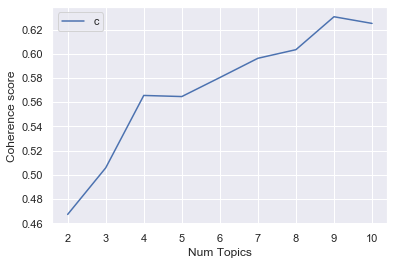

In [20]:
def compute_coherence_values(dictionary, corpus, texts, limit, start, step):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        print(num_topics)
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

start1 = 2 
limit1 = 11
step1 = 1

model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=start1, limit=limit1, step=step1)

x = range(start1, limit1, step1)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [21]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.4672
Num Topics = 3  has Coherence Value of 0.5057
Num Topics = 4  has Coherence Value of 0.5655
Num Topics = 5  has Coherence Value of 0.5646
Num Topics = 6  has Coherence Value of 0.5803
Num Topics = 7  has Coherence Value of 0.5962
Num Topics = 8  has Coherence Value of 0.6034
Num Topics = 9  has Coherence Value of 0.6305
Num Topics = 10  has Coherence Value of 0.625


In [22]:
optimal_model = model_list[7] # Number of Topics = 9
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.054*"people" + 0.035*"live" + 0.030*"arrive" + 0.027*"orthodox" + '
  '0.024*"offer" + 0.024*"cave" + 0.022*"area" + 0.019*"sight" + 0.019*"buy" + '
  '0.019*"man"'),
 (1,
  '0.069*"site" + 0.061*"find" + 0.058*"build" + 0.044*"ground" + '
  '0.033*"local" + 0.033*"monastery" + 0.028*"road" + 0.025*"round" + '
  '0.025*"large" + 0.022*"thing"'),
 (2,
  '0.096*"day" + 0.086*"worth" + 0.067*"time" + 0.040*"guide" + 0.027*"long" + '
  '0.024*"leave" + 0.024*"tomb" + 0.021*"ago" + 0.021*"expensive" + '
  '0.021*"include"'),
 (3,
  '0.104*"guide" + 0.051*"tour" + 0.035*"climb" + 0.027*"close" + '
  '0.027*"stone" + 0.021*"open" + 0.021*"travel" + 0.021*"view" + '
  '0.021*"world" + 0.019*"hear"'),
 (4,
  '0.050*"history" + 0.044*"carve" + 0.041*"difficult" + 0.038*"give" + '
  '0.032*"woman" + 0.026*"wall" + 0.023*"explain" + 0.020*"structure" + '
  '0.017*"cost" + 0.017*"due"'),
 (5,
  '0.049*"ticket" + 0.044*"city" + 0.038*"building" + 0.035*"year" + '
  '0.032*"hard" + 0.029*"r

In [23]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,5.0,0.1439,"ticket, city, building, year, hard, recommend,...",I do recommend to visit Lalibela churches and ...
1,1,1.0,0.1406,"site, find, build, ground, local, monastery, r...",Easy access to churches from Lilibela Town Cen...
2,2,2.0,0.1876,"day, worth, time, guide, long, leave, tomb, ag...",I have waited a long time to see this church a...
3,3,8.0,0.1370,"small, visit, pay, priest, fee, money, entranc...",During Genna (Ehtiopian Christmas) youre surel...
4,4,7.0,0.1293,"walk, experience, back, bit, expensive, town, ...",The churches are not cute by European standard...
5,5,7.0,0.1705,"walk, experience, back, bit, expensive, town, ...","Yes, you should go. Yes you should hire a guid..."
6,6,5.0,0.1607,"ticket, city, building, year, hard, recommend,...",My expectations of rock hewn churches were lai...
7,7,7.0,0.1333,"walk, experience, back, bit, expensive, town, ...",The entry ticket of 50$ - which go directly in...
8,8,2.0,0.1985,"day, worth, time, guide, long, leave, tomb, ag...",The two clusters of rock hewn churches in Lali...
9,9,7.0,0.1498,"walk, experience, back, bit, expensive, town, ...","Go there, it is unique, but choose your travel..."


In [24]:
df_dominant_topic['Dominant_Topic'].value_counts()

8.0    42
2.0    42
7.0    38
0.0    36
6.0    33
4.0    33
3.0    31
5.0    31
1.0    28
Name: Dominant_Topic, dtype: int64

In [25]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet.head(10)

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.1817,"people, live, arrive, orthodox, offer, cave, a...",The inscription written on the stone is done i...
1,1.0,0.1781,"site, find, build, ground, local, monastery, r...",Thus is very different than the rock hewn chur...
2,2.0,0.1985,"day, worth, time, guide, long, leave, tomb, ag...",The two clusters of rock hewn churches in Lali...
3,3.0,0.1892,"guide, tour, climb, close, stone, open, travel...",Not sure if it is worth the long potholed driv...
4,4.0,0.1915,"history, carve, difficult, give, woman, wall, ...",Our guide was the key to the visit. He was a p...
5,5.0,0.1846,"ticket, city, building, year, hard, recommend,...",Rock-Hewn Churches mind-blowing no words to ex...
6,6.0,0.1897,"trip, part, group, inside, hour, start, countr...",This is a must do out in the Tigray region. Th...
7,7.0,0.1869,"walk, experience, back, bit, expensive, town, ...","Aksum is one of those ""holy places"" where one ..."
8,8.0,0.1922,"small, visit, pay, priest, fee, money, entranc...",I have NOT visited these churches. 50 USD entr...


In [26]:
sent_topics_sorteddf_mallet['Text'].values

array(['The inscription written on the stone is done in several languages, thus providing a key to interpretting languages previously indecipherable. It does for these languages what the Rosetta stone did for dead Mideastern languages.',
       'Thus is very different than the rock hewn churches in Lalibela as it is situated in an overhanging cave and, at 900 years old, slightly predates Lalibelas churches. It is not carved out of rock but built up of alternating layers of timbers and masonry...',
       'The two clusters of rock hewn churches in Lalibela are out of this world. We saw them over two days (which I would recommend) doing it on one day would be long and tireing. The clusters are linked so there is a preferred route which...',
       'Not sure if it is worth the long potholed drive from Addis Abeba. However interesting to see when one eventually gets there. The property is a bit neglected and perhaps depressing. Once needs a guided tour to understand the property. The road 

In [27]:
# # Number of Documents for Each Topic
# topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# # Percentage of Documents for Each Topic
# topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# # Topic Number and Keywords
# topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# # Concatenate Column wise
# df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# # Change Column names
# df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# # Show
# df_dominant_topics